# INFO3950 ps6

name: Kate Li

netid: kl739

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1) Stylometrics
In lec 20 (see lec20_sty.ipynb), we saw how to dimensionally reduce 50 dimensional data to build a k-means classifier to distinguish two authors, Shakespeare and Milton. The objective here is to repeat those steps with two more authors from nltk.corpus.gutenberg: Austen and Melville, and a fifth author Agatha Christie from gutenberg.org .

[For this problem and the next, it's convenient to use the preprocessed nltk data, see nltk_data for retrieval instructions.]

In [4]:
import nltk   #might need `conda install nltk`
# see note above
from nltk.corpus import gutenberg
nltk.download('gutenberg') 
nltk.download('shakespeare')
nltk.download('punkt') # not needed here, but for word_tokenize (on problem set)

[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/kateli/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     /Users/kateli/nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kateli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Part A
A. The remainder of this part follows the lec20_sty.ipynb code to create objects top60, M5, scaler5, M5_scaled, pca5, M5_new, km5 analogous to those in the linked code.

In an analog of cell [7], add definitions to import words from the additional two files 'austen-persuasion.txt' and 'melville-moby_dick.txt'. The latter has over 200,000 words, so to keep it commensurate in size, it can be truncated to the first 80000 words. It will then contribute only 16 blocks (of 5000 words) to the training data, just as for Milton and Austen.

Then add an additional fifteen 5000 word blocks of training data from the 20th century author Agatha Christie to the 61 blocks of training data above, using her "The Secret of Chimneys":

from urllib.request import urlopen
chimneys_url = 'https://www.gutenberg.org/cache/epub/65238/pg65238.txt'
chimneys = urlopen(chimneys_url).read().decode('utf-8')
chimneys_words = [w.lower() for w in nltk.word_tokenize(chimneys[876:439335]) if w[0].isalpha()]
(Note: That or any other texts from the web would have to be tokenized (see nltk_ch02 re accessing web corpora), which can be done using tools from earlier exercises (e.g., the regular expression [\w\']+, though for consistency it makes more sense to continue using the nltk tool as above: nltk.word_tokenize() is described in nltk_ch03, remember afterwards to lower case and remove punctuation. The above limits chimneys[779:439233] strip off the Gutenburg header/trailer material, leaving fifteen 5000 words blocks.)

In [6]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from collections import Counter

In [7]:
for fileid in gutenberg.fileids():
    print (fileid, len(gutenberg.words(fileid)))

austen-emma.txt 192427
austen-persuasion.txt 98171
austen-sense.txt 141576
bible-kjv.txt 1010654
blake-poems.txt 8354
bryant-stories.txt 55563
burgess-busterbrown.txt 18963
carroll-alice.txt 34110
chesterton-ball.txt 96996
chesterton-brown.txt 86063
chesterton-thursday.txt 69213
edgeworth-parents.txt 210663
melville-moby_dick.txt 260819
milton-paradise.txt 96825
shakespeare-caesar.txt 25833
shakespeare-hamlet.txt 37360
shakespeare-macbeth.txt 23140
whitman-leaves.txt 154883


In [8]:
shf = [fileid for fileid in gutenberg.fileids() if fileid.startswith('shakespeare')]
shf  #shakespeare files

['shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt']

In [9]:
shw = [w.lower() for fileid in shf for w in gutenberg.words(fileid) 
       if w[0].isalpha()]
# shakespeare words, punctuation removed;
mpw = [w.lower() for w in gutenberg.words('milton-paradise.txt') if w[0].isalpha()]
len(shw),len(mpw) #numbers of words

(69340, 80493)

In [10]:
austen_words = [w.lower() for w in gutenberg.words('austen-persuasion.txt') if w[0].isalpha()] # austen-persuasion words
melville_words = [w.lower() for w in gutenberg.words('melville-moby_dick.txt') if w[0].isalpha()][:80000] # melville moby dick words

len(austen_words), len(melville_words)

(84121, 80000)

In [11]:
from urllib.request import urlopen
chimneys_url = 'https://www.gutenberg.org/cache/epub/65238/pg65238.txt'
chimneys = urlopen(chimneys_url).read().decode('utf-8')
chimneys_words = [w.lower() for w in nltk.word_tokenize(chimneys[876:439335]) if w[0].isalpha()]

len(chimneys_words)

76423

i) For features, use the list of top60 words (since the vocabulary had been enlarged) from this set as in cell [9], but now from the five authors' texts. Then create an array M5 as in cell [10] but for all five authors, so it will have 13 + 16 + 16 + 16 + 15 = 76 lines, each with 60 entries, i.e., shape (76,60). Draw a plot, as in cell [12], of all 76 lines (using five separate colors, perhaps with colors b,g,r,y,C6, where the last is magenta-like).

In [13]:
texts = Counter(shw + mpw + austen_words + melville_words + chimneys_words)
top60, _ = zip(*texts.most_common(60))
print(top60)

('the', 'and', 'to', 'of', 'a', 'in', 'i', 'that', 'he', 'his', 'it', 'with', 'you', 'was', 'not', 'but', 'as', 'for', 'be', 'all', 'is', 's', 'had', 'him', 'her', 'on', 'this', 'at', 'my', 'so', 'by', 'from', 'she', 'what', 'me', 'or', 'they', 'have', 'no', 'their', 'there', 'which', 'said', 'one', 'now', 'we', 'will', 'were', 'then', 'your', 'more', 'them', 'if', 'who', 'when', 'been', 'do', 'would', 'are', 'd')


In [14]:
M5 = []
for corp in [shw, mpw, austen_words, melville_words, chimneys_words]:
    for i in range(0, len(corp) - 4999, 5000):
        freq = Counter(corp[i:i+5000])
        M5.append([freq[w] for w in top60])

M5 = np.array(M5).astype(np.float64)

In [15]:
def plot_format(ylab=''):
    plt.xticks(range(60), top60, rotation=270)
    plt.xlim(-1,60)
    plt.grid(axis='x', linestyle='dotted')
    plt.ylabel(ylab)
    plt.legend()

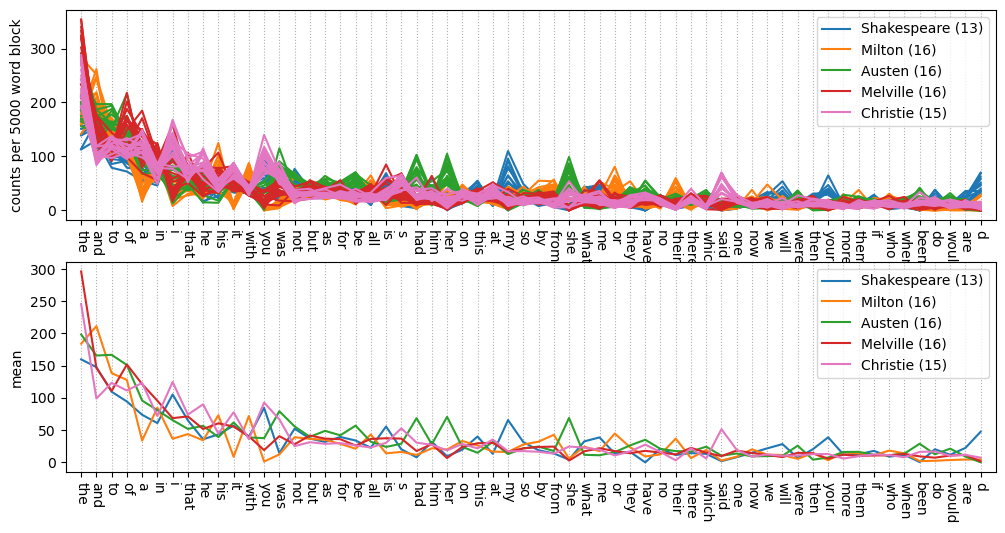

In [16]:
plt.figure(figsize = (12, 6))

lines = [13, 16, 16, 16, 15]
colors = ['C0', 'C1', 'C2', 'C3', 'C6']
labels = ['Shakespeare (13)', 'Milton (16)', 'Austen (16)', 'Melville (16)', 'Christie (15)']

plt.subplot(2, 1, 1)
start = 0
for i, size in enumerate(lines):
    plt.plot(M5[start:start + size].T, color = colors[i])
    plt.plot([-1], [100], color = colors[i], label = labels[i])
    start += size
plot_format('counts per 5000 word block')

plt.subplot(2, 1, 2)
start = 0
for i, size in enumerate(lines):
    mean = M5[start:start + size].mean(axis = 0)
    plt.plot(mean, color = colors[i], label = labels[i])
    start += size
plot_format('mean')
    
plt.show()

ii) Initialize a scaler5 for this data, and create an M5_scaled array, as in cell [13]. Fit a full PCA() to the data, and plot all sixty components of the full .explained_variance_ratio_ to see roughly why roughly .74 for cumulative explained variance could be a sensible choice of threshold.

In [18]:
scaler5 = preprocessing.StandardScaler()
M5_scaled = scaler5.fit_transform(M5)

pca = PCA()
M5_new = pca.fit_transform(M5_scaled)
evr = pca.explained_variance_ratio_

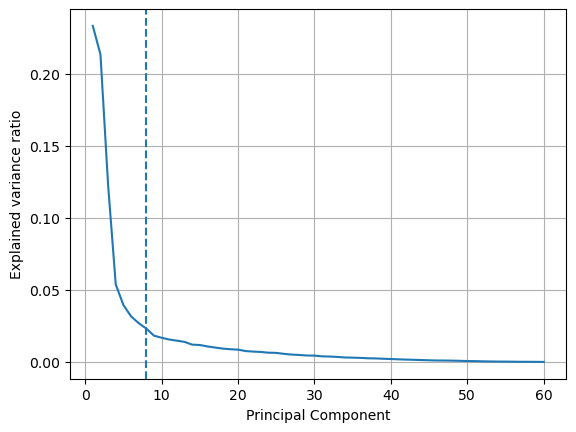

In [19]:
cumulative_var = evr.cumsum()
component_at_threshold = np.argmax(cumulative_var >= 0.74) + 1

plt.plot(np.arange(1, 61), evr)
#plt.axhline(y = 0.74, linestyle = '--')
plt.axvline(x = component_at_threshold, linestyle = '--')
plt.xlabel('Principal Component')
plt.ylabel('Explained variance ratio')
plt.grid(True)
plt.show()

iii) For the PCA dimensional reduction, modify cell [15] to use pca5 = PCA(.74), which will retain dimensions for at least 74% of the variance of the original data, as above. Determine from pca5.explained_variance_ratio_ the number of dimensions that is, and sum the variances to confirm they add up to greater than 74% .

In [21]:
pca5 = PCA(.74)  
M5_new = pca5.fit_transform(M5_scaled)
evr = pca5.explained_variance_ratio_
num_dimensions = pca5.n_components_
sum_var = evr.sum()

print(f"number of dimensions: {num_dimensions}")
print(f"sum of variances: {sum_var}")

number of dimensions: 8
sum of variances: 0.7452658458123997


### Part B
i) Define a km5 with k=5 clusters, on the M5_new = pca5.fit_transform(M5_scaled) data, meaning that the k-means will be trained on the higher dimensional data chosen by pca5. Check its accuracy score on the training data.

In [23]:
from sklearn.cluster import KMeans

In [24]:
km5 = KMeans(n_clusters = 5, random_state = 42)
km5.fit(M5_new)

def clusters_to_labels(cluster_labels, true_labels):
    map = {}
    for cluster in np.unique(cluster_labels):
        cluster_idx = np.where(cluster == cluster_labels)[0]
        cluster_true_labels = true_labels[cluster_idx]
        cluster_common_label = Counter(cluster_true_labels).most_common(1)[0][0]
        map[cluster] = cluster_common_label
    return map

cluster_labels = km5.labels_
true_labels = np.array([0]*13 + [1]*16 + [2]*16 + [3]*16 + [4]*15)
label_map = clusters_to_labels(cluster_labels, true_labels)
mapped_labels = np.array([label_map[label] for label in cluster_labels])

accuracy = np.mean(mapped_labels == true_labels)
print(f"accuracy: {accuracy}")

accuracy: 0.9473684210526315


ii) Make both 2d and 3d plots of the five author data from M5_new, with the 3d plot along the lines shown in the four author slide 8 of lec19_slides.pdf. Although the data is higher dimensional, you can plot just the first 2 or 3 components using plt.scatter(*M5_new.T[:2]) or ax.scatter(*M5_new.T[:3]). Also include the five k-means centers in both plots.

(For 3d, remember to use ax.set_box_aspect((1,1,1)) so that the vertical dimension isn't squeezed. Also you don't need to put the words on the axes, you can just leave the numerical values.)

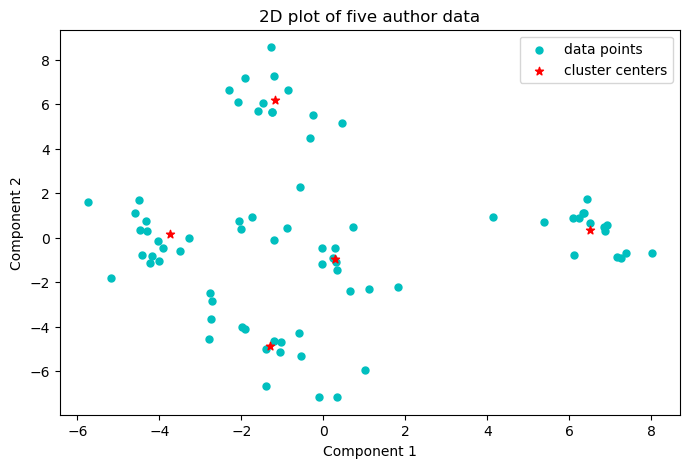

In [26]:
# 2d plot
plt.figure(figsize = (8, 5))
plt.scatter(*M5_new.T[:2], s = 25, c = 'c', label = 'data points')

centers = km5.cluster_centers_
plt.scatter(*centers[:, :2].T, c = 'r', marker = '*', label = 'cluster centers')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.title('2D plot of five author data')
plt.show()

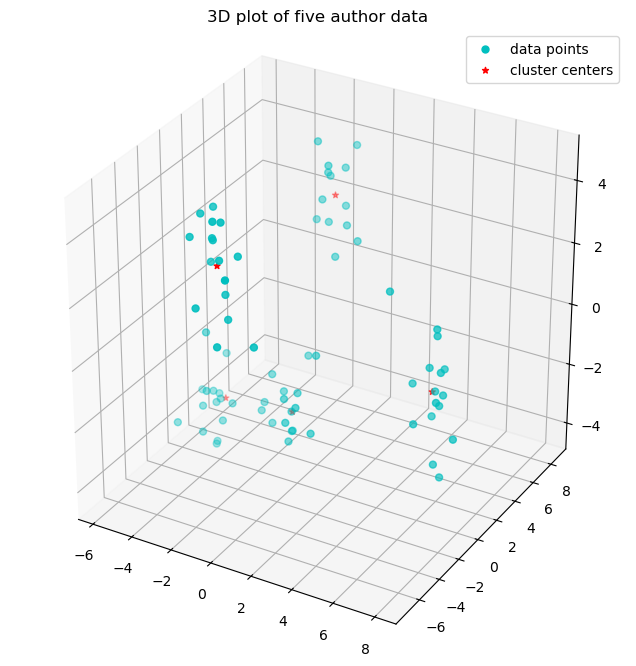

In [27]:
# 3d plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(*M5_new.T[:3], s = 25, c = 'c', label = 'data points')
ax.scatter(*centers[:, :3].T, c = 'r', marker = '*', label = 'cluster centers')
ax.set_box_aspect((1,1,1))
ax.set_title('3D plot of five author data')
ax.legend()
plt.show()

### Part C
Now assess the above k-means classifier on test data. For the test data, use: 1) the remaining portion of Melville (i.e., from word 80000 on, there should be 27 more blocks of 5000 words); 2) Also try the combined 'austen-emma.txt' and 'austen-sense.txt' (56 more blocks of 5000 words); 3) nltk.corpus.shakespeare contains five more Shakespeare plays (another 24 blocks of 5000 words, i.e., not counting caeser/hamlet/macbeth used above); 4) Also try some other Milton text, e.g., Paradise Regained from Gutenberg.org:

paradise_r_url = 'http://www.gutenberg.org/cache/epub/58/pg58.txt'
paradise_r = urlopen(paradise_r_url).read().decode('utf-8')
paradise_r_words = [w.lower() for w in nltk.word_tokenize(paradise_r[774:93588]) if w[0].isalpha()]
Then 5) Add additional test points for the fifth author taken from her "Murder on the Links":

links_url = 'https://www.gutenberg.org/cache/epub/58866/pg58866.txt'
links = urlopen(links_url).read().decode('utf-8')
links_words = [w.lower() for w in nltk.word_tokenize(links[823:373266]) if w[0].isalpha()]
This should provide a total of 27 + 56 + 24 + 3 + 12 = 122 blocks. Again use the scalar5() and pca5 fitted to only the training data to transform these points into the pca-reduced dimension space.

(It is important to use these quantities and km5 as trained earlier, i.e., without retraining using the .fit() method on the test data, since they should depend only on the training data. This is as in cell [21] of lec17_sty.ipynb, where only the .transform() and .predict() methods are used.)

In [29]:
from nltk.corpus import shakespeare
for fileid in shakespeare.fileids():
    print(fileid)

a_and_c.xml
dream.xml
hamlet.xml
j_caesar.xml
macbeth.xml
merchant.xml
othello.xml
r_and_j.xml


In [30]:
melville_test = [w.lower() for w in gutenberg.words('melville-moby_dick.txt') if w[0].isalpha()][80000:] # melville moby dick words

austen_comb_test = [w.lower() for w in gutenberg.words('austen-emma.txt') if w[0].isalpha()] + \
        [w.lower() for w in gutenberg.words('austen-sense.txt') if w[0].isalpha()]

ss_plays = ['a_and_c.xml', 'dream.xml', 'merchant.xml', 'othello.xml', 'r_and_j.xml']
shw_test = [w.lower() for fileid in ss_plays for w in shakespeare.words(fileid) if w[0].isalpha()]

paradise_r_url = 'http://www.gutenberg.org/cache/epub/58/pg58.txt' 
paradise_r = urlopen(paradise_r_url).read().decode('utf-8') 
paradise_r_words = [w.lower() for w in nltk.word_tokenize(paradise_r[774:93588]) if w[0].isalpha()] 

links_url = 'https://www.gutenberg.org/cache/epub/58866/pg58866.txt' 
links = urlopen(links_url).read().decode('utf-8') 
links_words = [w.lower() for w in nltk.word_tokenize(links[823:373266]) if w[0].isalpha()]

In [31]:
M5_test = []

for corp in [melville_test, austen_comb_test, shw_test, paradise_r_words, links_words]:
    for i in range(0, len(corp) - 4999, 5000):
        freq = Counter(corp[i:i+5000])
        M5_test.append([freq[w] for w in top60])

M5_test = np.array(M5_test).astype(np.float64)

i) What is the km5 test score, i.e., see if any of the 27 + 56 + 24 + 3 + 12 = 122 blocks of test data are classified incorrectly by the k-means classifier.

In [33]:
M5_test_scaled = scaler5.transform(M5_test)
M5_test_new = pca5.transform(M5_test_scaled)
pred = km5.predict(M5_test_new)
true_labels = np.array([0]*27 + [1]*56 + [2]*24 + [3]*3 + [4]*12)
label_map = clusters_to_labels(pred, true_labels)
test_map_labels = np.array([label_map[label] for label in pred])

accuracy = np.mean(test_map_labels == true_labels)
print(f"M5 test accuracy: {accuracy}")

M5 test accuracy: 1.0


ii) Redraw the 2d and 3d plots of B.ii, with the above test points added (with a different marker, e.g., 'd' for diamond for the test data), and colored according to their classification.

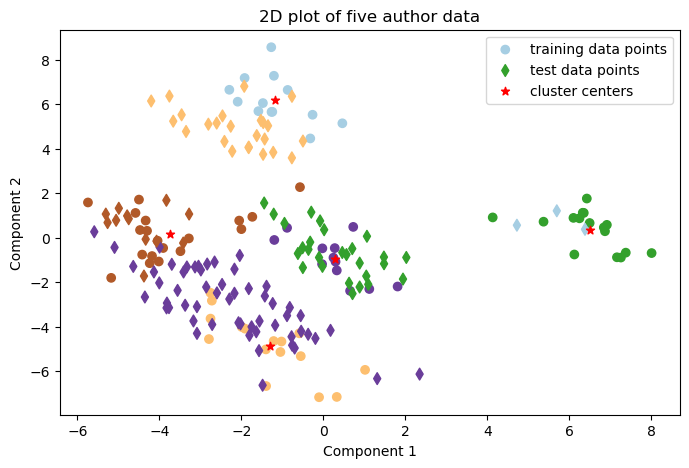

In [35]:
# 2d plot
plt.figure(figsize = (8, 5))
plt.scatter(*M5_new.T[:2], c = mapped_labels, cmap = 'Paired', marker = 'o', label = 'training data points')
plt.scatter(*M5_test_new.T[:2], c = pred, cmap = 'Paired', marker = 'd', label = 'test data points')

centers = km5.cluster_centers_
plt.scatter(*centers[:, :2].T, c = 'r', marker = '*', label = 'cluster centers')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.title('2D plot of five author data')
plt.show()

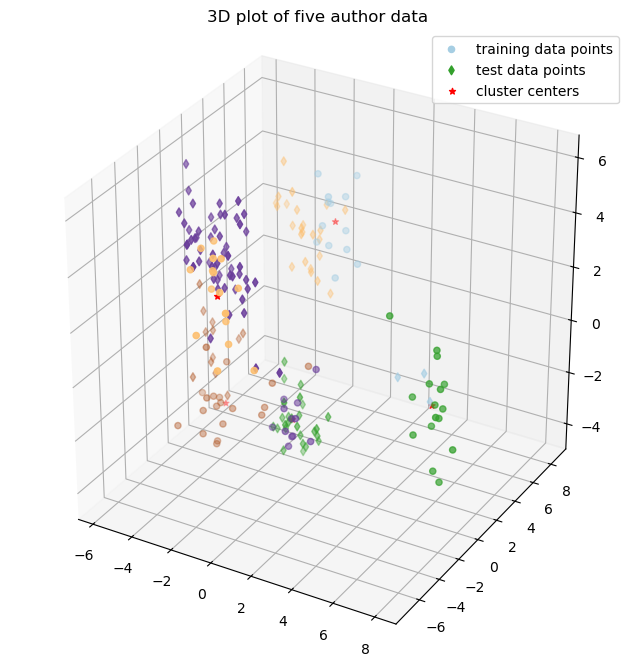

In [36]:
# 3d plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(*M5_new.T[:3], c = mapped_labels, cmap = 'Paired', marker = 'o', label = 'training data points')
ax.scatter(*M5_test_new.T[:3], c = pred, cmap = 'Paired', marker = 'd', label = 'test data points')

ax.scatter(*centers[:, :3].T, c = 'r', marker = '*', label = 'cluster centers')
ax.set_box_aspect((1,1,1))
ax.set_title('3D plot of five author data')
ax.legend()
plt.show()

### Part D
As for the twelve Hamilton/Madison disputed essays of the Federalist papers mentioned in Lec19, there are posthumous disputes among some of the above five authors regarding the two texts here: ps6texts.zip, which unpack to ps6text1.txt and ps6text2.txt .

In [38]:
text1 = open('ps6texts/ps6text1.txt', encoding = 'utf8').read()
text2 = open('ps6texts/ps6text2.txt', encoding = 'utf8').read()

i) Break ps6text1.txt up into 5000 word blocks as above -- you should find 35 blocks. (Remember again for consistency you should use nltk.word_tokenize() if you've been using it above, otherwise the regexp [\w\']+ for all of parts A-D). Determine the likely authorship of each of those blocks.

In [40]:
words1 = [w.lower() for w in nltk.word_tokenize(text1) if w[0].isalpha()]

blocks1 = []
for i in range(0, len(words1) - 4999, 5000):
    freq = Counter(words1[i:i+5000])
    blocks1.append([freq[w] for w in top60])

blocks1 = np.array(blocks1).astype(np.float64)
b_scaled1 = scaler5.transform(blocks1)
b_new1 = pca5.transform(b_scaled1)
pred1 = km5.predict(b_new1)
print(pred1)

[1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1]


According to our predictions, the word blocks for ps6text1.txt is has likely authorship of 0 or 1, which correspond to Shakespeare or Milton. 

ii) Make plots as in part B.ii, adding the points representing these 35 blocks, and a line connecting them. It might look something like the below (plotted using fmt '.-', except of course the lines aren't accurate and the training points and 5-means centers need to be added).

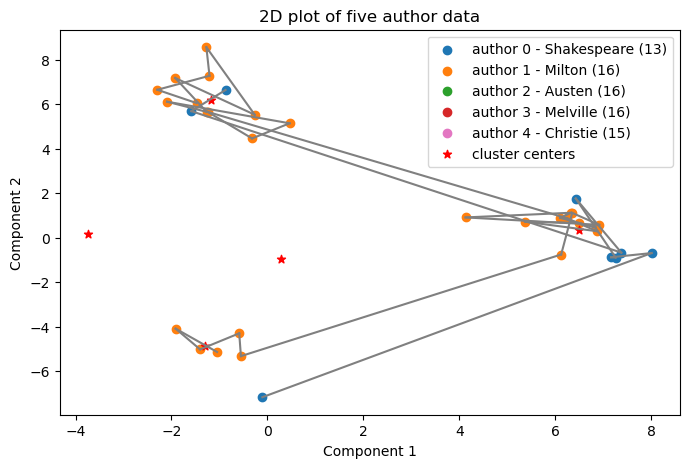

In [43]:
# 2d plot
plt.figure(figsize = (8, 5))

for i in range(5):
    idx = np.where(pred1 == i)[0]
    plt.scatter(*M5_new[idx, :2].T, c = colors[i], label = f"author {i} - {labels[i]}")
    
    for j in range(len(idx) - 1):
        plt.plot(*M5_new[idx[j:j+2]].T[:2], linestyle = '-', color = 'grey')

centers = km5.cluster_centers_
plt.scatter(*centers[:, :2].T, c = 'r', marker = '*', label = 'cluster centers')

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.title('2D plot of five author data')
plt.show()

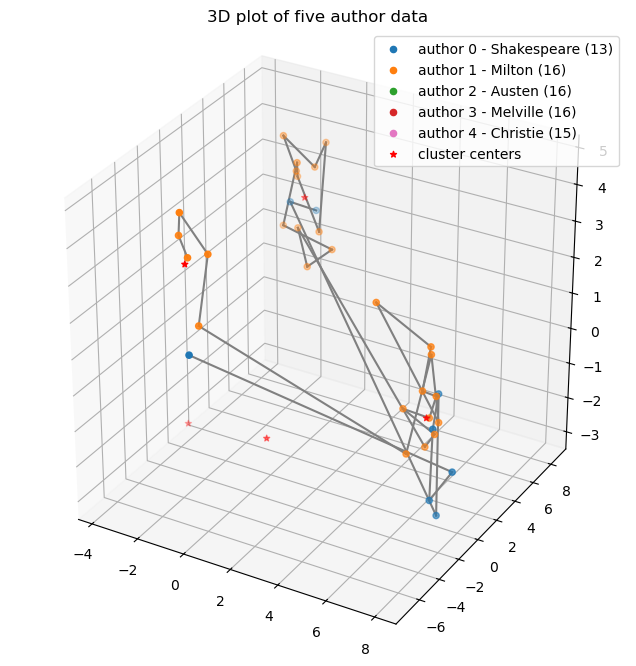

In [44]:
# 3d plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection = '3d')

for i in range(5):
    idx = np.where(pred1 == i)[0]
    ax.scatter(*M5_new[idx, :3].T, c = colors[i], label = f"author {i} - {labels[i]}")
    
    for j in range(len(idx) - 1):
        plt.plot(*M5_new[idx[j:j+2]].T[:3], linestyle = '-', color = 'grey')

ax.scatter(*centers[:, :3].T, c = 'r', marker = '*', label = 'cluster centers')
ax.set_box_aspect((1,1,1))
ax.set_title('3D plot of five author data')
ax.legend()
plt.show()

iii) Break ps6text2.txt up into 5000 word blocks as above -- you should find 35 blocks. Determine the likely authorship of each of those blocks.

In [46]:
words2 = [w.lower() for w in nltk.word_tokenize(text2) if w[0].isalpha()]

blocks2 = []
for i in range(0, len(words2) - 4999, 5000):
    freq = Counter(words2[i:i+5000])
    blocks2.append([freq[w] for w in top60])

blocks2 = np.array(blocks2).astype(np.float64)
b_scaled2 = scaler5.transform(blocks2)
b_new2 = pca5.transform(b_scaled2)
pred2 = km5.predict(b_new2)
print(pred2)

[2 2 2 2 0 0 0 3 3 3 3 3 3 3 3 1 1 1 1 1 1 4 4 4 4 4 4 4 4 2 2 2 2]


According to our predictions, the word blocks for ps6texts2.txt can be a any of the authors. Our predictions correspond to each of our 5 authors.

iv) Make 2d and 3d plots as in part D.ii, now adding to the plots from B.ii instead the points representing these 33 blocks.

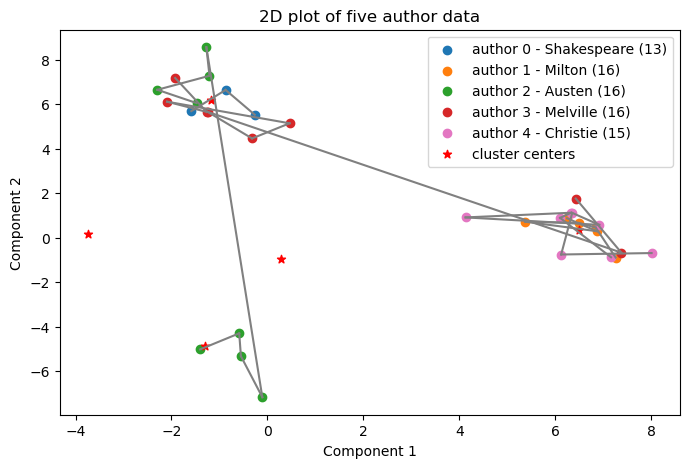

In [49]:
# 2d plot
plt.figure(figsize = (8, 5))

for i in range(5):
    idx = np.where(pred2 == i)[0]
    plt.scatter(*M5_new[idx, :2].T, c = colors[i], label = f"author {i} - {labels[i]}")
    
    for j in range(len(idx) - 1):
        plt.plot(*M5_new[idx[j:j+2]].T[:2], linestyle = '-', color = 'grey')

centers = km5.cluster_centers_
plt.scatter(*centers[:, :2].T, c = 'r', marker = '*', label = 'cluster centers')

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.title('2D plot of five author data')
plt.show()

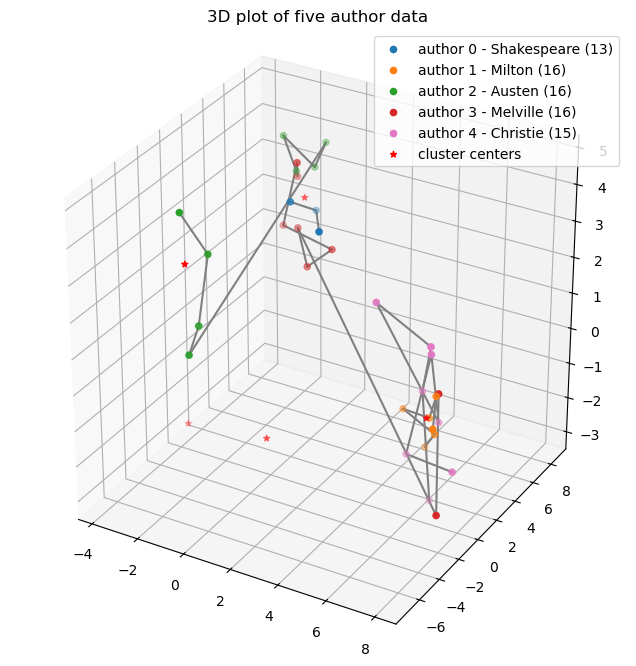

In [50]:
# 3d plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection = '3d')

for i in range(5):
    idx = np.where(pred2 == i)[0]
    ax.scatter(*M5_new[idx, :3].T, c = colors[i], label = f"author {i} - {labels[i]}")
    
    for j in range(len(idx) - 1):
        plt.plot(*M5_new[idx[j:j+2]].T[:3], linestyle = '-', color = 'grey')

ax.scatter(*centers[:, :3].T, c = 'r', marker = '*', label = 'cluster centers')
ax.set_box_aspect((1,1,1))
ax.set_title('3D plot of five author data')
ax.legend()
plt.show()